In [1]:
!nvidia-smi

Sun Jun 21 10:23:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Emergency Vehicle Classification

Emergency vs. Non-Emergency Vehicle Classification is a binary classification problem.

Try three approaches:
1. Fine-tune a pretrained model on ImageNet (e.g. ResNet)
2. Use a pretrained model as a fixed feature extractor
3. Train model from scratch

## Step 1: Check data distribution in training set

In [2]:
%%time

### COPY FILES TO COLAB ###
# GDRIVE_PATH = '/content/drive/My\ Drive/emergency-vehicle-classification/*'
# BASE_PATH = '/content/dataset/'
# !mkdir -p $BASE_PATH
# !cp -r $GDRIVE_PATH $BASE_PATH
# !ls -l $BASE_PATH

### WITHOUT COPYING FILES ###
GDRIVE_PATH = '/content/drive/My Drive/emergency-vehicle-classification'
BASE_PATH = GDRIVE_PATH

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [3]:
import os
TRAIN_DIR = 'train_SOaYf6m'
TRAIN_CSV = os.path.join(BASE_PATH, TRAIN_DIR, 'train.csv')
TEST_CSV = os.path.join(BASE_PATH, 'test_vc2kHdQ.csv')
SAMPLE_CSV = os.path.join(BASE_PATH, 'sample_submission_yxjOnvz.csv')

In [4]:
import pandas as pd
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56b5bb2f98>]],
      dtype=object)

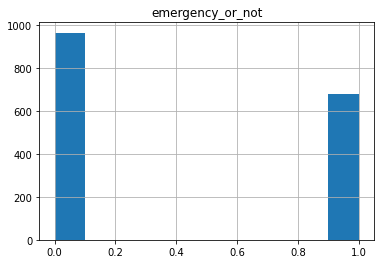

In [5]:
train_df.hist()

There are many more negative samples than positive samples. Stratification needs to be used when making the train/test split.

## Step 2: Make train/test split

In [6]:
from sklearn.model_selection import train_test_split

train_set_df, test_set_df = train_test_split(train_df, stratify=train_df['emergency_or_not'])

def calculate_ratio(df):
  pos = (df['emergency_or_not'] == 0).sum()
  return pos / len(df)

print(f'Train set ratio: {calculate_ratio(train_set_df)}')
print(f'Test set ratio: {calculate_ratio(test_set_df)}')

Train set ratio: 0.5858995137763371
Test set ratio: 0.587378640776699


## Step 3: Create Dataset and DataLoader

In [7]:
from torch.utils.data import Dataset, DataLoader
from skimage import io
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Dataset
class EVDataset(Dataset):

  def __init__(self, df, transforms=None):
    self.df = df
    self.transforms = transforms

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.iloc[idx, 0]
    img_path = os.path.join(BASE_PATH, TRAIN_DIR, 'images', img_name)
    image = Image.fromarray(io.imread(img_path))

    if self.transforms:
      image = self.transforms(image)
    else:
      image = torch.from_numpy(image.transpose((2, 0, 1)).astype(np.float32))

    img_class = self.df.iloc[idx, 1]

    return image, torch.tensor(img_class, dtype=torch.long)
    # img_path = os.path.join(TRAIN_DIR, )

data_transforms = transforms.Compose([
  transforms.RandomAffine(10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=(-0.2, 0.2, -0.2, 0.2)),
  transforms.ToTensor(),
  transforms.RandomErasing(),
])

train_ds = EVDataset(train_set_df, transforms=data_transforms)
test_ds = EVDataset(test_set_df, transforms=transforms.Compose([transforms.ToTensor()]))

# Dataloader
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=16)

# Step 4a: Use a pre-trained model

In [8]:
# Model

import torchvision.models as models
model = models.resnet.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
from torch import nn

# Reshape output layer
model.fc = nn.Linear(model.fc.in_features, 2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda:0


In [12]:
# Create optimizer and loss function

from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [13]:
# training loop

from tqdm import tqdm
import time

EPOCHS = 30
val_acc_hist = []

max_val_acc = 0.0

for epoch in range(EPOCHS):
  start = time.time()
  print(f'Epoch {epoch+1}: ', end='')
  time.sleep(1)
  model.train()

  running_loss = 0.0
  running_corrects = 0

  pbar_train = tqdm(train_dl, leave=False)
  for img, label in pbar_train:

    pbar_train.set_description(f'(train)')

    optimizer.zero_grad()

    inputs = img.to(device)
    labels = label.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / len(train_dl.dataset)
  epoch_acc = running_corrects.double() / len(train_dl.dataset)
  print(f'Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}, {time.time() - start:.2f}s', end=', ')
  time.sleep(1)
  start = time.time()

  model.eval()
  test_running_loss = 0.0
  test_running_corrects = 0

  pbar_test = tqdm(test_dl, leave=False)
  for img, label in pbar_test:
    pbar_test.set_description(f'(test)')
    optimizer.zero_grad()

    inputs = img.to(device)
    labels = label.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    loss = criterion(outputs, labels)

    test_running_loss += loss.item()
    test_running_corrects += torch.sum(preds == labels.data)

  test_loss = test_running_loss / len(test_dl.dataset)
  test_acc = test_running_corrects.double() / len(test_dl.dataset)
  print(f'Test loss: {test_loss:.4f}, acc: {test_acc:.4f}', end=', ')
  time.sleep(1)

  print(f'{time.time() - start:.2f}s')

  if test_acc > max_val_acc:
    torch.save(model.state_dict(), 'best_model.dat')
    max_val_acc = test_acc
    print('Model saved...')

Epoch 1: 

Train loss: 0.0226, acc: 0.8412, 155.52s, 

Test loss: 0.0118, acc: 0.9296, 208.06s
Model saved...
Epoch 2: 

Train loss: 0.0146, acc: 0.9222, 13.97s, 

Test loss: 0.0082, acc: 0.9563, 3.78s
Model saved...
Epoch 3: 

Train loss: 0.0109, acc: 0.9335, 13.95s, 

Test loss: 0.0143, acc: 0.9126, 3.74s
Epoch 4: 

Train loss: 0.0074, acc: 0.9587, 13.87s, 

Test loss: 0.0127, acc: 0.9223, 3.78s
Epoch 5: 

Train loss: 0.0086, acc: 0.9627, 13.91s, 

Test loss: 0.0084, acc: 0.9612, 3.75s
Model saved...
Epoch 6: 

Train loss: 0.0059, acc: 0.9619, 13.94s, 

Test loss: 0.0113, acc: 0.9296, 3.77s
Epoch 7: 

Train loss: 0.0079, acc: 0.9514, 13.98s, 

Test loss: 0.0091, acc: 0.9563, 3.76s
Epoch 8: 

Train loss: 0.0071, acc: 0.9571, 13.90s, 

Test loss: 0.0116, acc: 0.9369, 3.99s
Epoch 9: 

Train loss: 0.0063, acc: 0.9595, 13.96s, 

Test loss: 0.0109, acc: 0.9539, 3.75s
Epoch 10: 

Train loss: 0.0033, acc: 0.9741, 13.88s, 

Test loss: 0.0101, acc: 0.9539, 3.73s
Epoch 11: 

Train loss: 0.0038, acc: 0.9733, 13.87s, 

Test loss: 0.0109, acc: 0.9490, 3.74s
Epoch 12: 

Train loss: 0.0039, acc: 0.9749, 13.95s, 

Test loss: 0.0079, acc: 0.9709, 3.77s
Model saved...
Epoch 13: 

Train loss: 0.0050, acc: 0.9676, 13.96s, 

Test loss: 0.0151, acc: 0.9369, 3.72s
Epoch 14: 

Train loss: 0.0019, acc: 0.9919, 13.87s, 

Test loss: 0.0102, acc: 0.9587, 3.71s
Epoch 15: 

Train loss: 0.0035, acc: 0.9789, 13.89s, 

Test loss: 0.0104, acc: 0.9587, 3.76s
Epoch 16: 

Train loss: 0.0026, acc: 0.9854, 13.92s, 

Test loss: 0.0106, acc: 0.9563, 3.76s
Epoch 17: 

Train loss: 0.0046, acc: 0.9814, 13.90s, 

Test loss: 0.0106, acc: 0.9539, 3.74s
Epoch 18: 

Train loss: 0.0046, acc: 0.9741, 13.87s, 

Test loss: 0.0113, acc: 0.9587, 3.73s
Epoch 19: 

Train loss: 0.0027, acc: 0.9854, 13.85s, 

Test loss: 0.0112, acc: 0.9612, 3.76s
Epoch 20: 

Train loss: 0.0027, acc: 0.9806, 13.95s, 

Test loss: 0.0130, acc: 0.9563, 3.75s
Epoch 21: 

Train loss: 0.0018, acc: 0.9903, 13.90s, 

Test loss: 0.0114, acc: 0.9466, 3.70s
Epoch 22: 

Train loss: 0.0040, acc: 0.9903, 13.94s, 

Test loss: 0.0108, acc: 0.9612, 3.73s
Epoch 23: 

Train loss: 0.0031, acc: 0.9838, 13.82s, 

Test loss: 0.0153, acc: 0.9466, 3.73s
Epoch 24: 

Train loss: 0.0029, acc: 0.9838, 13.88s, 

Test loss: 0.0133, acc: 0.9442, 3.71s
Epoch 25: 

Train loss: 0.0022, acc: 0.9862, 13.92s, 

Test loss: 0.0119, acc: 0.9515, 3.71s
Epoch 26: 

Train loss: 0.0020, acc: 0.9870, 13.86s, 

Test loss: 0.0119, acc: 0.9515, 3.72s
Epoch 27: 

Train loss: 0.0026, acc: 0.9854, 13.85s, 

Test loss: 0.0137, acc: 0.9417, 3.72s
Epoch 28: 

Train loss: 0.0030, acc: 0.9838, 13.88s, 

Test loss: 0.0143, acc: 0.9612, 3.71s
Epoch 29: 

Train loss: 0.0047, acc: 0.9716, 13.85s, 

Test loss: 0.0266, acc: 0.9078, 3.75s
Epoch 30: 

Train loss: 0.0045, acc: 0.9692, 13.81s, 

Test loss: 0.0157, acc: 0.9345, 3.74s


In [14]:
# Test loading model after saving

loaded_model = models.resnet.resnet101()
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 2)
loaded_model.load_state_dict(torch.load('best_model.dat'))
loaded_model.eval()
loaded_model.to(device)

test_running_loss = 0.0
test_running_corrects = 0

pbar_test = tqdm(test_dl, leave=False)
for img, label in pbar_test:
  pbar_test.set_description(f'(test)')
  optimizer.zero_grad()

  inputs = img.to(device)
  labels = label.to(device)

  outputs = loaded_model(inputs)
  _, preds = torch.max(outputs, 1)

  loss = criterion(outputs, labels)

  test_running_loss += loss.item()
  test_running_corrects += torch.sum(preds == labels.data)

test_loss = test_running_loss / len(test_dl.dataset)
test_acc = test_running_corrects.double() / len(test_dl.dataset)
print(f'Test loss: {test_loss:.4f}, acc: {test_acc:.4f}', end=', ')
time.sleep(1)

Test loss: 0.0079, acc: 0.9709, 

# Step 4b: Use a pre-trained model for feature extraction

# Step 4c: Use ResNet18 architecture, train from scratch

In [ ]:
# Model

import torchvision.models as models
resnet18 = models.resnet18()

In [ ]:
from torch import nn

# Reshape output layer
resnet18.fc = nn.Linear(512, 2)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet18 = resnet18.to(device)

cuda:0


In [ ]:
# Create optimizer and loss function

from torch import optim

optimizer = optim.Adam(resnet18.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
# training loop

from tqdm import tqdm
import time

EPOCHS = 30
val_acc_hist = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1} - ', end='')
  time.sleep(1)

  resnet18.train()

  running_loss = 0.0
  running_corrects = 0

  pbar_train = tqdm(train_dl, leave=False)
  for img, label in pbar_train:

    pbar_train.set_description(f'(train)')

    optimizer.zero_grad()

    inputs = img.to(device)
    labels = label.to(device)

    outputs = resnet18(inputs)
    _, preds = torch.max(outputs, 1)

    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / len(train_dl.dataset)
  epoch_acc = running_corrects.double() / len(train_dl.dataset)
  print(f'Train loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}', end=', ')
  time.sleep(1)

  resnet18.eval()
  test_running_loss = 0.0
  test_running_corrects = 0

  pbar_test = tqdm(test_dl, leave=False)
  for img, label in pbar_test:
    pbar_test.set_description(f'(test)')
    optimizer.zero_grad()

    inputs = img.to(device)
    labels = label.to(device)

    outputs = resnet18(inputs)
    _, preds = torch.max(outputs, 1)

    loss = criterion(outputs, labels)

    test_running_loss += loss.item()
    test_running_corrects += torch.sum(preds == labels.data)

  test_loss = test_running_loss / len(test_dl.dataset)
  test_acc = test_running_corrects.double() / len(test_dl.dataset)
  pbar_test.write(f'Test loss: {test_loss:.4f}, acc: {test_acc:.4f}')
  time.sleep(1)

Epoch 1 - 

Train loss: 0.0030, acc: 0.9830, 

Test loss: 0.0346, acc: 0.8714
Epoch 2 - 

Train loss: 0.0039, acc: 0.9814, 

Test loss: 0.0440, acc: 0.8447
Epoch 3 - 

Train loss: 0.0069, acc: 0.9643, 

Test loss: 0.0380, acc: 0.8714
Epoch 4 - 

Train loss: 0.0030, acc: 0.9846, 

Test loss: 0.0468, acc: 0.8180
Epoch 5 - 

Train loss: 0.0021, acc: 0.9878, 

Test loss: 0.0455, acc: 0.8398
Epoch 6 - 

Train loss: 0.0036, acc: 0.9895, 

Test loss: 0.0351, acc: 0.8786
Epoch 7 - 

Train loss: 0.0046, acc: 0.9708, 

Test loss: 0.1465, acc: 0.6529
Epoch 8 - 

Train loss: 0.0043, acc: 0.9724, 

Test loss: 0.0295, acc: 0.8932
Epoch 9 - 

Train loss: 0.0023, acc: 0.9870, 

Test loss: 0.0383, acc: 0.8689
Epoch 10 - 

Train loss: 0.0013, acc: 0.9951, 

Test loss: 0.0317, acc: 0.9078
Epoch 11 - 

Train loss: 0.0012, acc: 0.9951, 

Test loss: 0.0302, acc: 0.8835
Epoch 12 - 

Train loss: 0.0015, acc: 0.9976, 

Test loss: 0.0343, acc: 0.8786
Epoch 13 - 

Train loss: 0.0063, acc: 0.9716, 

Test loss: 0.0375, acc: 0.8252
Epoch 14 - 

Train loss: 0.0113, acc: 0.9408, 

Test loss: 0.0456, acc: 0.7888
Epoch 15 - 

Train loss: 0.0046, acc: 0.9724, 

Test loss: 0.0273, acc: 0.8908
Epoch 16 - 

Train loss: 0.0011, acc: 0.9959, 

Test loss: 0.0296, acc: 0.8883
Epoch 17 - 

Train loss: 0.0009, acc: 0.9968, 

Test loss: 0.0285, acc: 0.8932
Epoch 18 - 

Train loss: 0.0009, acc: 0.9959, 

Test loss: 0.0315, acc: 0.8811
Epoch 19 - 

Train loss: 0.0003, acc: 0.9992, 

Test loss: 0.0382, acc: 0.8689
Epoch 20 - 

Train loss: 0.0005, acc: 0.9968, 

Test loss: 0.0339, acc: 0.8981
Epoch 21 - 

Train loss: 0.0006, acc: 0.9976, 

Test loss: 0.0314, acc: 0.9053
Epoch 22 - 

Train loss: 0.0007, acc: 0.9968, 

Test loss: 0.0339, acc: 0.8835
Epoch 23 - 

Train loss: 0.0006, acc: 0.9976, 

Test loss: 0.0377, acc: 0.8835
Epoch 24 - 

Train loss: 0.0005, acc: 0.9984, 

Test loss: 0.0365, acc: 0.8762
Epoch 25 - 

Train loss: 0.0005, acc: 0.9968, 

Test loss: 0.0336, acc: 0.8908
Epoch 26 - 

Train loss: 0.0005, acc: 0.9968, 

Test loss: 0.0337, acc: 0.8859
Epoch 27 - 

Train loss: 0.0010, acc: 0.9959, 

Test loss: 0.0361, acc: 0.8835
Epoch 28 - 

Train loss: 0.0098, acc: 0.9489, 

Test loss: 0.0400, acc: 0.8058
Epoch 29 - 

Train loss: 0.0055, acc: 0.9635, 

Test loss: 0.0335, acc: 0.8908
Epoch 30 - 

Train loss: 0.0022, acc: 0.9878, 

Test loss: 0.0377, acc: 0.8617


# Step 5: Generate predictions on test set

In [ ]:
# View sample submission
sample_df = pd.read_csv(SAMPLE_CSV)
sample_df.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [15]:
pred_df = pd.read_csv(TEST_CSV)

# Dummy column so that dataset does not need to be modified
pred_df['emergency_or_not'] = 0

pred_df.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,0
2,2082.jpg,0
3,808.jpg,0
4,1907.jpg,0


In [ ]:
len(pred_df)

706

In [19]:
pred_ds = EVDataset(pred_df, transforms=transforms.Compose([transforms.ToTensor()]))

In [17]:
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
predictions = []
pred_dl = DataLoader(pred_ds, batch_size=32)
for img, _ in tqdm(pred_dl):
  _, pred = torch.max(loaded_model(img.to(device)), 1)
  predictions += pred.tolist()


100%|██████████| 23/23 [05:26<00:00, 14.18s/it]


In [21]:
print(predictions)
print(len(predictions))

[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 

In [22]:
pred_df['emergency_or_not'] = predictions
pred_df.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0


In [23]:
pred_df.to_csv('predictions.csv', index=False)